In [176]:
import os

import collections
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import spacy

from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS 
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.decomposition import TruncatedSVD
from collections import defaultdict

pd.set_option('display.max_colwidth', -1)
sns.set()
%matplotlib inline

In [177]:
path = os.path.join('..', 'cache')
filename = 'train.csv'
filepath = os.path.join(path, filename)
filepath

'../cache/train.csv'

In [178]:
!ls {path}

test.csv  train.csv


In [179]:
df_train = pd.read_csv(os.path.join(path, 'train.csv'))
df_train.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province as a nation in the 1960s?,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you encourage people to adopt and not shop?",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity affect space geometry?,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg hemispheres?,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain bike by just changing the tyres?,0


In [180]:
df_test =  pd.read_csv(os.path.join(path, 'test.csv'))
df_test.head()

,qid,question_text
0,00014894849d00ba98a9,My voice range is A2-C5. My chest voice goes up to F4. Included sample in my higher chest range. What is my voice type?
1,000156468431f09b3cae,How much does a tutor earn in Bangalore?
2,000227734433360e1aae,What are the best made pocket knives under $200-300?
3,0005e06fbe3045bd2a92,Why would they add a hypothetical scenario that’s impossible to happen in the link below? It shows what 800 meters rise in sea level would look like.
4,00068a0f7f41f50fc399,What is the dresscode for Techmahindra freshers?


In [50]:
df_train.shape

(1306122, 3)

In [51]:
np.unique(df_train['target'])

array([0, 1])

In [52]:
len(df_train)

1306122

In [53]:
df_train['target'].mean()

0.06187017751787352

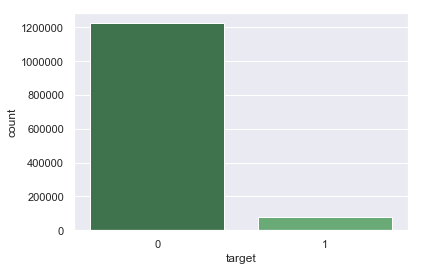

In [54]:
plt.figure(figsize=(6,4))
sns.countplot(x="target", data=df_train, palette="Greens_d");

*df_train unbalanced : only 6% of dataset vith positive values*

In [183]:
df_train.loc[df_train['target'] == 1].head(30)

,qid,question_text,target
22,0000e91571b60c2fb487,Has the United States become the largest dictatorship in the world?,1
30,00013ceca3f624b09f42,Which babies are more sweeter to their parents? Dark skin babies or light skin babies?,1
110,0004a7fcb2bf73076489,If blacks support school choice and mandatory sentencing for criminals why don't they vote Republican?,1
114,00052793eaa287aff1e1,"I am gay boy and I love my cousin (boy). He is sexy, but I dont know what to do. He is hot, and I want to see his di**. What should I do?",1
115,000537213b01fd77b58a,Which races have the smallest penis?,1
119,00056d45a1ce63856fc6,Why do females find penises ugly?,1
127,0005de07b07a17046e27,How do I marry an American woman for a Green Card? How much do they charge?,1
144,00068875d7c82a5bcf88,"Why do Europeans say they're the superior race, when in fact it took them over 2,000 years until mid 19th century to surpass China's largest economy?",1
156,0006ffd99a6599ff35b3,Did Julius Caesar bring a tyrannosaurus rex on his campaigns to frighten the Celts into submission?,1
167,00075f7061837807c69f,In what manner has Republican backing of 'states rights' been hypocritical and what ways have they actually restricted the ability of states to make their own laws?,1


In [56]:
X = df_train.loc[:, 'question_text']
y = df_train.loc[:, 'target']
X.shape, y.shape

((1306122,), (1306122,))

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=42, stratify=y)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((653061,), (653061,), (653061,), (653061,))

In [58]:
X_train.head()

130809     Why did you become a data science manager and ...
36523      Is it true that Mexicans are treated like seco...
1109227    Why should I not see a psychiatrist who is rel...
349685       Why does China want to capture other countries?
341120     What has been your best patient interaction as...
Name: question_text, dtype: object

In [59]:
df_train1 = df_train[df_train["target"]==1]
df_train0 = df_train[df_train["target"]==0]

In [60]:
len(df_train1['question_text'])

80810

In [61]:
len(df_train0['question_text'])

1225312

In [62]:
len(df_train.loc[df_train['target'] == 1]['question_text'])

80810

In [63]:
#text = str(df_train['question_text'])
text_insincere = str(df_train1['question_text'])
type(text_insincere)

str

In [64]:
df_train["quest_len"] = df_train["question_text"].apply(lambda x: len(x))

In [65]:
df_train["quest_len"][0]

72

/Users/hellososo/bin/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


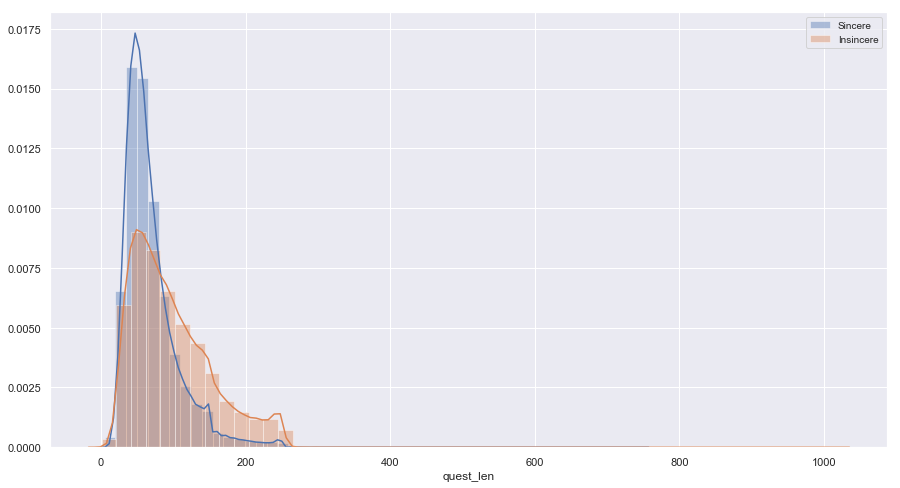

In [66]:
sincere = df_train[df_train["target"] == 0]
insincere = df_train[df_train["target"] == 1]

plt.figure(figsize = (15, 8))
sns.distplot(sincere["quest_len"], bins = 50, label = "Sincere")
sns.distplot(insincere["quest_len"], bins = 50, label = "Insincere")
plt.legend(fontsize = 10)
plt.show()


In [81]:
#thanks to https://www.kaggle.com/kaosmonkey/visualize-sincere-vs-insincere-words
class Vocabulary(object):
    
    def __init__(self):
        self.vocab = {}
        self.STOPWORDS = set()
        self.STOPWORDS = set(stopwords.words('english'))
        
    def build_vocab(self, lines):
        for line in lines:
            for word in line.split(' '):
                word = word.lower()
                if (word in self.STOPWORDS):
                    continue
                if (word not in self.vocab):
                    self.vocab[word] = 0
                self.vocab[word] +=1 
    
    def generate_ngrams(text, n_gram=1):
        """arg: text, n_gram"""
        token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
        ngrams = zip(*[token[i:] for i in range(n_gram)])
        return [" ".join(ngram) for ngram in ngrams]
    
    def horizontal_bar_chart(df, color):
        trace = go.Bar(
            y=df["word"].values[::-1],
            x=df["wordcount"].values[::-1],
            showlegend=False,
            orientation = 'h',
            marker=dict(
            color=color,
            ),
        )
        return trace

In [187]:
sincere_vocab = Vocabulary()
sincere_vocab.build_vocab(df_train[df_train['target'] == 0]['question_text'])
sincere_vocabulary = sorted(sincere_vocab.vocab.items(), reverse=True, key=lambda kv: kv[1])
for word, count in sincere_vocabulary[:5]:
    print(word, count)

best 60816
get 58731
would 57105
people 37960
like 37618


In [188]:
insincere_vocab = Vocabulary()
insincere_vocab.build_vocab(df_train[df_train['target'] == 1]['question_text'])
insincere_vocabulary = sorted(insincere_vocab.vocab.items(), reverse=True, key=lambda kv: kv[1])
for word, count in insincere_vocabulary[:5]:
    print(word, count)

people 11036
like 5708
trump 4893
women 4757
would 4126


In [70]:
df_sincere_vocab = pd.DataFrame(sincere_vocabulary, columns=['word_sincere', 'frequency'])
df_sincere_vocab.head()

,word_sincere,frequency
0,best,60816
1,get,58731
2,would,57105
3,people,37960
4,like,37618


In [71]:
df_insincere_vocab = pd.DataFrame(insincere_vocabulary, columns=['word_insincere', 'frequency'])
df_insincere_vocab.head()

,word_insincere,frequency
0,people,11036
1,like,5708
2,trump,4893
3,women,4757
4,would,4126


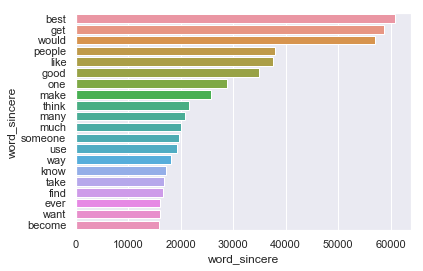

In [72]:
ax1 = sns.barplot(y='word_sincere', x='frequency', data=df_sincere_vocab[:20])
ax1.set_xlabel('word_sincere');

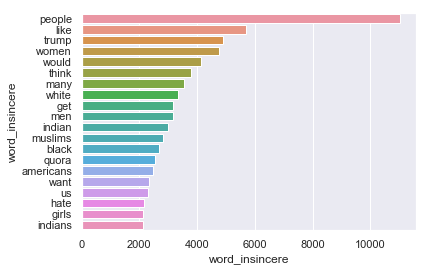

In [73]:
ax2 = sns.barplot(y='word_insincere', x='frequency', data=df_insincere_vocab[:20])
ax2.set_xlabel('word_insincere');

In [74]:
stopwords = set(stopwords.words("english"))

In [75]:
wordcloud = WordCloud(background_color='black',
                    stopwords = stopwords,
                    random_state = 43,
                    width=800, 
                    height=400)
wordcloud

In [76]:
wordcloud.generate(text_insincere)

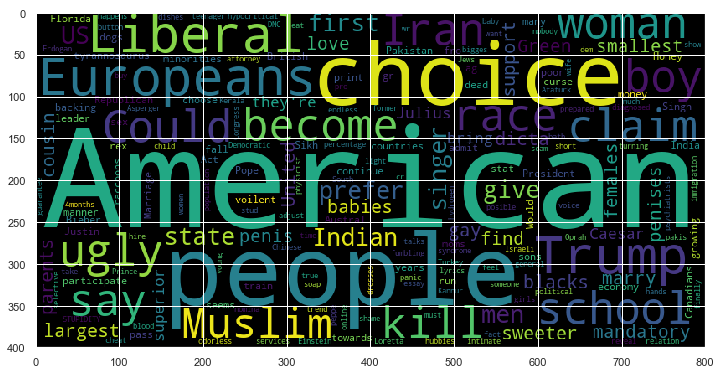

In [77]:
plt.figure(figsize=(12,8))
plt.imshow(wordcloud);

In [78]:
df_train1.head()

,qid,question_text,target
22,0000e91571b60c2fb487,Has the United States become the largest dicta...,1
30,00013ceca3f624b09f42,Which babies are more sweeter to their parents...,1
110,0004a7fcb2bf73076489,If blacks support school choice and mandatory ...,1
114,00052793eaa287aff1e1,I am gay boy and I love my cousin (boy). He is...,1
115,000537213b01fd77b58a,Which races have the smallest penis?,1


In [79]:
text = df_train.loc[:, 'question_text']
text.head()

0    How did Quebec nationalists see their province...
1    Do you have an adopted dog, how would you enco...
2    Why does velocity affect time? Does velocity a...
3    How did Otto von Guericke used the Magdeburg h...
4    Can I convert montra helicon D to a mountain b...
Name: question_text, dtype: object

In [36]:
nlp = spacy.load('en_core_web_sm',disable=['parser','ner'])
nlp

In [37]:
%%time
spacy_docs = nlp.pipe(X_train)
spacy_docs

CPU times: user 7 µs, sys: 1 µs, total: 8 µs
Wall time: 11 µs


In [38]:
%%time
lst = list(spacy_docs)
lst[1]

CPU times: user 15min 53s, sys: 3min 33s, total: 19min 27s
Wall time: 15h 31min 31s


In [39]:
lst[1][12].is_stop

True

In [40]:
spacy_docs = nlp.pipe(X_train)
lemmas = [[t.lemma_ if t.lemma_ != "-PRON-" else t.text for t in lst] for lst in spacy_docs]
lemmas[:1]

[['why',
  'do',
  'you',
  'become',
  'a',
  'data',
  'science',
  'manager',
  'and',
  'stop',
  'be',
  'an',
  'individual',
  'contributor',
  '?']]

In [41]:
lemmas_as_strings = [" ".join(x) for x in lemmas]
lemmas_as_strings

['why do you become a data science manager and stop be an individual contributor ?',
 'be it true that mexicans be treat like second class citizen in the united states ?',
 'why should I not see a psychiatrist who be relate to me ?',
 'why do china want to capture other country ?',
 'what have be your good patient interaction as a doctor ?',
 'how can I remove semi - permanent blue hair dye from my naturally blonde hair ?',
 'where we find dr roy chaudhary network analysis e book in pdf ?',
 'someone from other state register a fake case of accident by my vehicle and they be ask for money as compensation for his death , so what should we do ?',
 'why the journalistic value be decline around the world as medium report bias opinion instead of fact ?',
 'as a minor , can I get test for depression without my family find out ?',
 'how do I sprout chilli seed ?',
 'how do you train a havanese puppy ?',
 'be there a reasonably repeatable path to take if you want to become a ceo of company ?',

In [82]:
## Get the bar chart from sincere questions ##
freq_dict = defaultdict(int)
for sent in sincere['question_text']:
    for word in Vocabulary.generate_ngrams(sent, 2):
        freq_dict[word] += 1
fd_sorted_sincere = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1]))
fd_sorted_sincere.columns = ["word", "wordcount"]

In [83]:
fd_sorted_sincere = fd_sorted_sincere.sort_values(['wordcount'], ascending=False)
fd_sorted_sincere.head(5)

,word,wordcount
4008118,best way,6973
4008117,year old,2972
4008116,will happen,2084
4008115,many people,1931
4008114,computer science,1870


In [85]:
## Get the bar chart from insincere questions ##
freq_dict = defaultdict(int)
for sent in insincere['question_text']:
    for word in Vocabulary.generate_ngrams(sent, 2):
        freq_dict[word] += 1
fd_sorted_insincere = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1]))
fd_sorted_insincere.columns = ["word", "wordcount"]

In [86]:
fd_sorted_insincere = fd_sorted_insincere.sort_values(['wordcount'], ascending=False)
fd_sorted_insincere.head(5)

,word,wordcount
497383,donald trump,1076
497382,white people,673
497381,black people,653
497380,many people,383
497379,united states,360


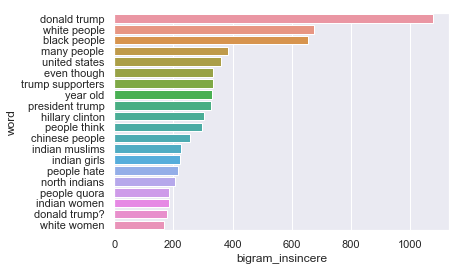

In [87]:
ax = sns.barplot(x='wordcount', y='word', data=fd_sorted_insincere[:20])
ax.set_xlabel('bigram_insincere');

In [88]:
fd_sorted_insincere.shape, fd_sorted_sincere.shape

((497384, 2), (4008119, 2))

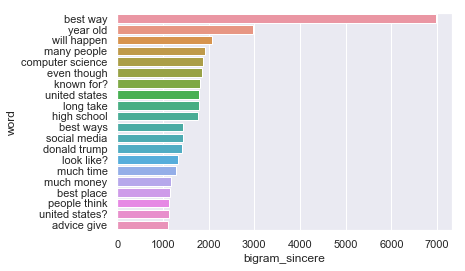

In [89]:
ax = sns.barplot(x='wordcount', y='word', data=fd_sorted_sincere[:20])
ax.set_xlabel('bigram_sincere');

Trigram

In [90]:
## Get the bar chart from insincere questions ##
freq_dict = defaultdict(int)
for sent in insincere['question_text']:
    for word in Vocabulary.generate_ngrams(sent, 3):
        freq_dict[word] += 1
fd_sorted_insincere = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1]))
fd_sorted_insincere.columns = ["word", "wordcount"]

In [92]:
fd_sorted_insincere = fd_sorted_insincere.sort_values(['wordcount'], ascending=False)
fd_sorted_insincere.head(10)

,word,wordcount
555222,will donald trump,43
555221,black lives matter,42
555220,long will take,38
555219,kim jong un,36
555218,12 year old,35
555217,people still believe,33
555216,14 year old,33
555215,united states america,31
555214,ask stupid questions,30
555213,think donald trump,30


**Countvectorizer + Multinomial NaiveBayes**

In [164]:
cvec = CountVectorizer(stop_words='english')
tf = cvec.fit_transform(lemmas_as_strings)
tf

<653061x121853 sparse matrix of type '<class 'numpy.int64'>'
	with 3670400 stored elements in Compressed Sparse Row format>

In [165]:
type(lemmas_as_strings)

list

In [166]:
mnb = MultinomialNB()

In [167]:
pipe = Pipeline([('cvec', cvec),('mnb', mnb)])
pipe

Pipeline(memory=None,
     steps=[('cvec', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)), ('mnb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [168]:
pipe.fit(lemmas_as_strings, y_train)

Pipeline(memory=None,
     steps=[('cvec', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)), ('mnb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [169]:
y_pred = pipe.predict(X_test)
y_pred

array([1, 0, 0, ..., 0, 1, 0])

In [186]:
pipe.predict_proba?

In [170]:
pipe.score(X_test, y_test)

0.9183843469446192

In [171]:
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.98      0.94      0.96    612656
           1       0.40      0.66      0.50     40405

   micro avg       0.92      0.92      0.92    653061
   macro avg       0.69      0.80      0.73    653061
weighted avg       0.94      0.92      0.93    653061



In [172]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[573108,  39548],
       [ 13752,  26653]])

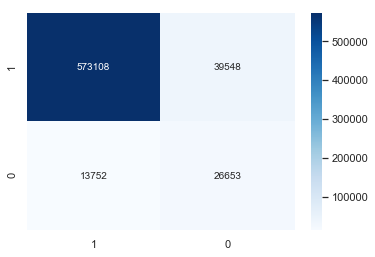

In [173]:
sns.heatmap(cm, cmap='Blues', xticklabels=y_test.unique(), yticklabels=y_test.unique(), annot=True, fmt='.0f');

f1-score @ 0.5 for insincere target

Tfidvectorizer + Multinomial NaiveBayes

In [155]:
tfid = TfidfVectorizer(stop_words='english')

In [156]:
tfid_ft = tfid.fit_transform(lemmas_as_strings)

In [157]:
pipe = Pipeline([('tfid', tfid),('mnb', mnb)])
pipe

Pipeline(memory=None,
     steps=[('tfid', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
...rue,
        vocabulary=None)), ('mnb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [158]:
pipe.fit(lemmas_as_strings, y_train)

Pipeline(memory=None,
     steps=[('tfid', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
...rue,
        vocabulary=None)), ('mnb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [159]:
y_pred = pipe.predict(X_test)

In [160]:
pipe.score(X_test, y_test)

0.9411632297748602

In [161]:
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.94      1.00      0.97    612656
           1       0.68      0.09      0.16     40405

   micro avg       0.94      0.94      0.94    653061
   macro avg       0.81      0.54      0.57    653061
weighted avg       0.93      0.94      0.92    653061



In [162]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[610963,   1693],
       [ 36731,   3674]])

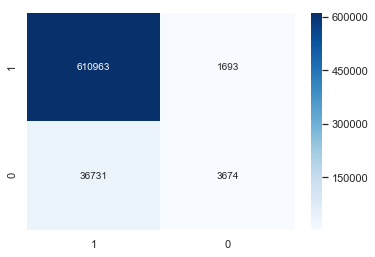

In [163]:
sns.heatmap(cm, cmap='Blues', xticklabels=y_test.unique(), yticklabels=y_test.unique(), annot=True, fmt='.0f');

In [103]:
lr = LogisticRegression()

In [104]:
pipe = Pipeline([('cvec', cvec),('lr', lr)])
pipe

Pipeline(memory=None,
     steps=[('cvec', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        ...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [105]:
pipe.fit(lemmas_as_strings, y_train)

/Users/hellososo/bin/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
     steps=[('cvec', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        ...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [106]:
y_pred = pipe.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [107]:
pipe.score(X_test, y_test)

0.9484841385414227

In [108]:
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.96      0.99      0.97    612656
           1       0.66      0.35      0.46     40405

   micro avg       0.95      0.95      0.95    653061
   macro avg       0.81      0.67      0.72    653061
weighted avg       0.94      0.95      0.94    653061



**Resampling using imbalanced-learn API**

1- CondensedNearestNeighbour

In [ ]:
cnn = CondensedNearestNeighbour(random_state=42)

In [ ]:
svd = TruncatedSVD(n_components=20)

In [ ]:
svd_ = svd.fit_transform(tf)

In [ ]:
type(svd_)

In [ ]:
df_svd_ = pd.DataFrame(svd_)
df_svd_.head()

In [ ]:
X_target_0, y_target_1 = df_svd_, y_train
X_target_0, y_target_1

In [ ]:
X_target_0.shape, y_target_1.shape

In [ ]:
%%time
#X__target_res, y_target_res = cnn.fit_resample(X_target_0, y_target_1)


**Meta Features:**

In [ ]:
df_train["num_words"] = df_train["question_text"].apply(lambda x: len(str(x).split()))
df_test["num_words"] = df_test["question_text"].apply(lambda x: len(str(x).split()))
df_train["num_words"].head()